In [1]:
import stockinator as st
import yfinance as yf
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import requests
import datetime
import time
import os
import sys
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

In [43]:
all_data = pd.read_pickle('stocks/sp500_1d.pkl')
stocklist = st.unique_list([x[0] for x in all_data.columns.values])
total_stocks = len(stocklist)

In [56]:
exportList = pd.DataFrame(columns=[
    'Stock', 'RSI', 'Price', 
    '90 Avg Volume', '10 Avg Volume', 
    'EMA_1', 'EMA_2', 'EMA_3', 
    '52 Week Low', '52 Week High', 'Pct of 52 High'])

offset = 500
n = -1
for stock in stocklist:
    n += 1
    #print("Index {} of {} Stock [{}] \r".format(n, total_stocks, stock))
    sys.stdout.write("Index {} of {} Stock [{}] \r".format(n, total_stocks-1, stock))
    sys.stdout.flush()

    df = all_data[stock]
    if offset > 0:
        df = df[:-offset]

    df = df.dropna(how='all')
    if df.empty:
        continue

    df = st.calculate_rsi(df)
    df = st.calculate_ema(df, periods=[13, 34, 89])
    df = st.calculate_volume(df)
    df = st.calculate_mfi(df)

    try:
        moving_average_long_21 = df["EMA_3"][-21]
    except Exception:
        moving_average_long_21 = 0

    try:
        currentClose = df["Adj Close"][-1]
        low_of_52week = min(df["Adj Close"][-260:])
        high_of_52week = max(df["Adj Close"][-260:])
        moving_average_short = df["EMA_1"][-1]
        moving_average_medium = df["EMA_2"][-1]
        moving_average_long = df["EMA_3"][-1]
        avg_volume_90 = df['90 Avg Volume'][-1]
        avg_volume_10 = df['10 Avg Volume'][-1]
        rsi = df['RSI'][-1]
    except Exception:
        continue

    try:
        assert(currentClose > 10)
        assert(avg_volume_90 > 250000)
        #assert(moving_average_50 > moving_average_200)
        #assert(moving_average_200 > moving_average_200_21)
        assert(currentClose > moving_average_short > moving_average_medium > moving_average_long > moving_average_long_21)
        assert(currentClose >= (1.3 * low_of_52week))
        assert(currentClose >= (.75 * high_of_52week))
        assert(rsi > 60)
        assert(avg_volume_10 > avg_volume_90)
    except AssertionError:
        continue
    except IndexError as e:
        continue
    except Exception as e:
        print(e)

    try:
        #final.append(stock)
        #index.append(n)
        #dataframe = pd.DataFrame(list(zip(final, index)), columns =['Company', 'Index'])
        #dataframe.to_csv('stocks.csv')

        exportList = exportList.append(
            {
                'Stock': stock, 
                'RSI': rsi, 
                'Price': currentClose,
                '90 Avg Volume': avg_volume_90,
                '10 Avg Volume': avg_volume_10,
                'EMA_1': moving_average_short, 
                'EMA_2': moving_average_medium, 
                'EMA_3': moving_average_long, 
                '52 Week Low': low_of_52week, 
                '52 Week High': high_of_52week,
                'Pct of 52 High': (currentClose / high_of_52week) * 100
            }, ignore_index=True)
    except Exception as e:
        print(e)

In [57]:
print(exportList.sort_values('Pct of 52 High', ascending=True))
exportList.sort_values('Pct of 52 High', ascending=False).to_csv('stocks.csv', index=False)

   Stock        RSI       Price  90 Avg Volume  10 Avg Volume       EMA_1       EMA_2       EMA_3  52 Week Low  52 Week High  Pct of 52 High
6   TTWO  64.232637  113.070000     2700005.56      3215110.0  110.591063  106.504554  106.299728    65.059998    126.669998       89.263441
9    DVN  76.239021   40.127621     8067638.89      8846680.0   39.364711   36.911682   36.053799    28.430534     43.353344       92.559459
4    MOS  62.073057   27.327515     4835341.11      5051520.0   26.892115   26.374455   25.812773    18.992048     28.296453       96.575759
1     EA  62.715830  130.860001     3564122.22      4577870.0  127.528234  124.425997  121.539812    95.730003    133.759995       97.831942
2    MRO  74.714467   20.666664    13382315.56     15784780.0   20.281107   18.809567   17.348835    10.417338     20.852060       99.110897
0    STE  68.291668  100.769630      375294.44       564670.0   99.815632   97.000664   93.810913    71.586929    101.533340       99.247823
7   EXPD  74.

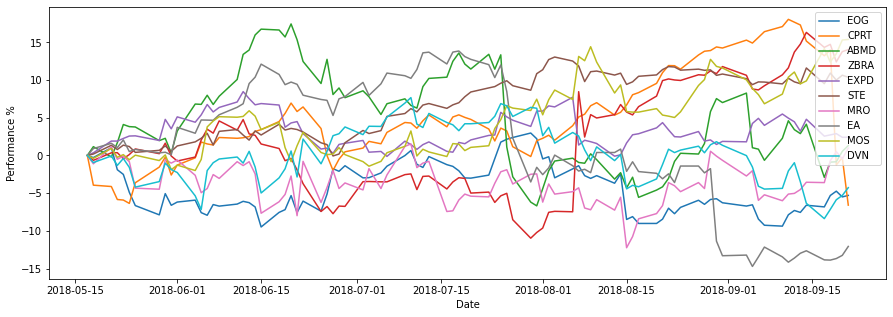

In [59]:
top10 = exportList.sort_values('Pct of 52 High', ascending=False)[0:10]
plt.figure(figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("Performance %")
for s in top10.Stock.values:
    perf = all_data[s][-offset:-offset+89]
    change = (perf.Close - perf.iloc[0]['Close']) / perf.iloc[0].Close
    plt.plot(perf.index, change*100, label=s)
plt.legend()
plt.show()